In [146]:
import sys
sys.path.append('../src')

from pkg_torchrl.env import make_env
from pkg_ddpg_td3.utils.map_eval import *

from configs import BaseConfig

In [147]:
config = BaseConfig()
env = make_env(config, generate_map=generate_eval_map152)
env41 = make_env(config, generate_map=generate_eval_map171)

/opt/homebrew/anaconda3/envs/rlboost/lib/python3.11/site-packages/extremitypathfinder/extremitypathfinder.py:178: UserWarning: called .prepare() on already prepared map. skipping...
  warnings.warn(
/Users/tamino/dev/robot_learning/DRL-Traj-Planner/notebooks/../src/pkg_ddpg_td3/environment/environment.py:176: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return {"success": torch.tensor(self.reached_goal).unsqueeze(0),
/opt/homebrew/anaconda3/envs/rlboost/lib/python3.11/site-packages/extremitypathfinder/extremitypathfinder.py:178: UserWarning: called .prepare() on already prepared map. skipping...
  warnings.warn(
/Users/tamino/dev/robot_learning/DRL-Traj-Planner/notebooks/../src/pkg_ddpg_td3/environment/environment.py:176: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return {"success": torch.tensor(self.reached_goal).unsqueeze(0),


In [155]:
import seaborn as sns
cmp = sns.color_palette("colorblind")

baseline_color = cmp[0]
cr_base_color = cmp[1]
ours_color = cmp[2]
other_colors = cmp[3:]

cmp

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [148]:
_ = env.reset()
_ = env41.reset()

In [149]:
from pkg_ddpg_td3.environment import plot
import matplotlib.pyplot as plt
import numpy as np

In [150]:
import os
from collections import defaultdict

folder_path = "../Model/cr_experiment/trajectories"

map_list = [
    defaultdict(list),
    defaultdict(list),
]

for filename in os.listdir(folder_path):
    map_key = filename.split("(")[-1].split(",")[1].strip()
    map_idx = 0 if int(map_key) == 7 else 1

    if filename.startswith("1"):
        file_path = os.path.join(folder_path, filename)
        loaded_traj = np.loadtxt(file_path, delimiter=",")
        map_list[map_idx]['base'].append(loaded_traj)
    elif filename.startswith("2"):
        file_path = os.path.join(folder_path, filename)
        loaded_traj = np.loadtxt(file_path, delimiter=",")
        map_list[map_idx]['cr'].append(loaded_traj)

In [151]:
import matplotlib as mpl
mpl.rcParams['legend.numpoints'] = 1

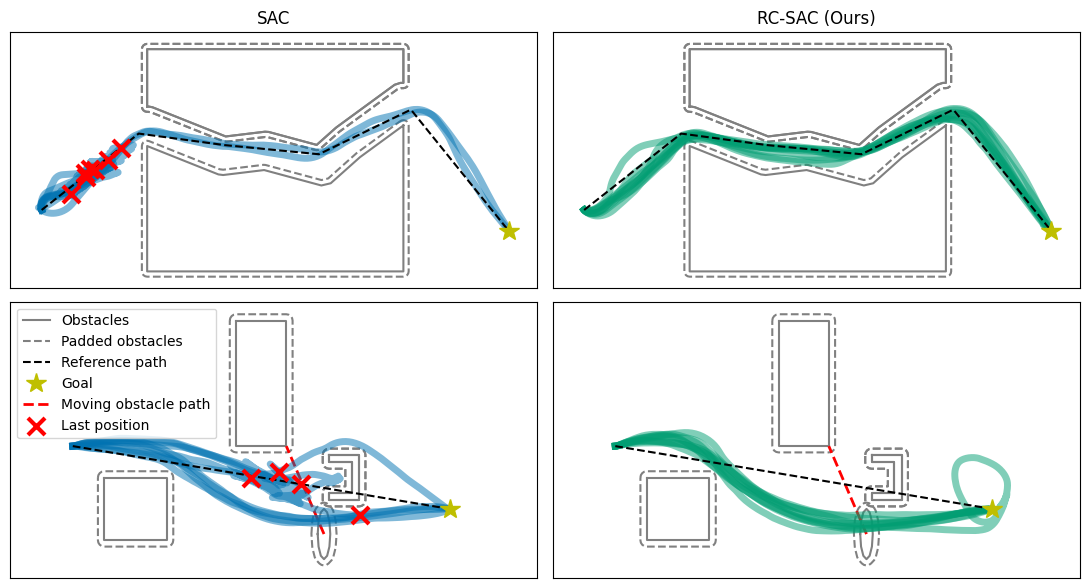

In [165]:
fig, axs = plt.subplots(2, 2, figsize=(11, 6))        

for ax in axs[0]:
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-8, 42)
    plot.obstacles(ax, env.unwrapped.obstacles, fmt='gray')
    plot.obstacles(ax, env.unwrapped.obstacles, padded=True,
                linestyle="--", label="Padded obstacles", fmt='gray')
    plot.reference_path(ax, env.unwrapped.path, zorder=4)

close_to_goal2 = False

for ax in axs[1]:
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 42)
    plot.obstacles(ax, env41.unwrapped.obstacles, fmt='gray')
    plot.obstacles(ax, env41.unwrapped.obstacles, padded=True,
                linestyle="--", label="Padded obstacles", fmt='gray')
    plot.reference_path(ax, env41.unwrapped.path, zorder=4)
    plot.line(ax, [[25., 3.], [22., 10.]], "red", linestyle="--", linewidth=2, label="Moving obstacle path")

for traj in map_list[1]['base']:
    plot.line(axs[0,0], traj, color=baseline_color, alpha=0.5, linewidth=5)
    last_point = traj[-1]

    close_to_goal = np.linalg.norm(last_point - env.unwrapped.goal.position) < 1.0
    if not close_to_goal and not close_to_goal2:
        axs[0,0].scatter(last_point[0], last_point[1], marker='x',
                       color='r', s=150, linewidth=3, zorder=5)
        
for traj in map_list[1]['cr']:
    plot.line(axs[0,1], traj, color=ours_color, alpha=0.5, linewidth=5)
    last_point = traj[-1]

    close_to_goal = np.linalg.norm(last_point - env.unwrapped.goal.position) < 1.0
    if not close_to_goal and not close_to_goal2:
        axs[0,1].scatter(last_point[0], last_point[1], marker='x',
                       color='r', s=150, linewidth=3, zorder=5)

has_coll = False
for traj in map_list[0]['base']:
    plot.line(axs[1,0], traj, color=baseline_color, alpha=0.5, linewidth=5)
    last_point = traj[-1]

    close_to_goal = np.linalg.norm(last_point - env41.unwrapped.goal.position) < 1.0
    if not close_to_goal and not close_to_goal2:
        if not has_coll:
            has_coll = True
            axs[1,0].scatter(last_point[0], last_point[1], marker='x',
                        color='r', s=150, linewidth=3, zorder=5, label="Last position")
        else:
            axs[1,0].scatter(last_point[0], last_point[1], marker='x',
                        color='r', s=150, linewidth=3, zorder=5)
        
for traj in map_list[0]['cr']:
    plot.line(axs[1,1], traj, color=ours_color, alpha=0.5, linewidth=5)
    last_point = traj[-1]

    close_to_goal = np.linalg.norm(last_point - env41.unwrapped.goal.position) < 1.0
    if not close_to_goal and not close_to_goal2:
        axs[1,1].scatter(last_point[0], last_point[1], marker='x',
                       color='r', s=150, linewidth=3, zorder=5)
       
axs[0,0].set_title("SAC")
axs[0,1].set_title("RC-SAC (Ours)")
axs[1,0].legend(loc="upper left", numpoints=1)

plt.tight_layout()
plt.savefig("../figures/trajectory_comparison.png", dpi=400)
plt.show()

In [10]:
# plot training maps
from pkg_ddpg_td3.utils.map import (
    generate_map_corridor,
    generate_map_dynamic,
    generate_map_mpc,
    generate_map_dynamic_convex_obstacle,
)

maps = [generate_map_dynamic, generate_map_corridor, generate_map_dynamic_convex_obstacle, generate_map_mpc()]

In [136]:
import math
import random

import numpy as np
import shapely.ops
from shapely.geometry import LineString, Polygon, JOIN_STYLE, Point

from pkg_ddpg_td3.environment import MobileRobot, Obstacle, Boundary, Goal, MapDescription

def generate_map_corridor_plot() -> MapDescription:
    """
    Generates a map with a randomized narrow corridor ando no dynamic obstacles.
    """

    max_angle = math.pi / 2

    wall_padding = 5
    corridor_padding = 1.

    coords = np.asarray([(0, 0), (wall_padding, 0)])
    angle = 0
    for i in range(3):
        lo = -max_angle - angle
        hi = max_angle - angle
        dangle = math.pi / 4 #random.uniform(lo, hi)
        dangle = dangle**2 / (hi if dangle > 0 else lo)
        angle += dangle

        length = 4#random.uniform(2, 8)
        coords = np.vstack((coords, coords[i + 1, :] + length * np.asarray((math.cos(angle), math.sin(angle)))))
    coords = np.vstack((coords, coords[-1, :] + (wall_padding, 0)))

    init_state = np.array([coords[0, 0], coords[0, 1], random.uniform(0, 2 * math.pi), 0, 0])
    robot = MobileRobot(init_state)
    goal = Goal(coords[-1])

    corridor = LineString(coords)
    minx, miny, maxx, maxy = corridor.bounds

    wall_padding = 5
    pminx = minx - wall_padding
    pminy = miny - wall_padding
    pmaxx = maxx + wall_padding
    pmaxy = maxy + wall_padding

    boundary = Boundary([(pminx, pminy), (pmaxx, pminy), (pmaxx, pmaxy), (pminx, pmaxy)])

    pminx = minx + wall_padding
    pmaxx = maxx - wall_padding

    obstacles = []
    if pminx < pmaxx:
        box = Polygon([(pminx, pminy), (pmaxx, pminy), (pmaxx, pmaxy), (pminx, pmaxy)])
        left = corridor.parallel_offset(corridor_padding, 'left', join_style=JOIN_STYLE.mitre, mitre_limit=1)
        right = corridor.parallel_offset(corridor_padding, 'right', join_style=JOIN_STYLE.mitre, mitre_limit=1)

        eps = 1e-3

        split = shapely.ops.split(box, right)
        test = Point((pminx + eps, pminy + eps))
        for geom in split.geoms:
            if geom.contains(test):
                obstacles.append(Obstacle.create_mpc_static(geom.exterior.coords[:-1]))
                break
        
        split = shapely.ops.split(box, left)
        test = Point((pminx + eps, pmaxy - eps))
        for geom in split.geoms:
            if geom.contains(test):
                obstacles.append(Obstacle.create_mpc_static(geom.exterior.coords[:-1]))
                break
    
    return robot, boundary, obstacles, goal


def generate_dyn_plot() -> MapDescription:
    """
    Generates a randomized map with many dynamic obstalces
    """

    init_state = np.array([5., 5., 0., 0, 0])
    robot = MobileRobot(init_state)
    boundary = Boundary([(0, 0), (40, 0), (40, 20), (0, 20)])
    obstacles = []


    # rand = random.uniform(0,5 )
    x = 10.
    y = 5. 
    w = 5.
    h = 5.
    x0 = x - w / 2
    y0 = y - h / 2
    obstacles.append(Obstacle.create_mpc_static([(x0, y0), (x0 + w, y0), (x0 + w, y0 + h), (x0, y0 + h)]))
    
    x = 20.
    y = 15
    w = 4.
    h = 10.
    x0 = x - w / 2
    y0 = y - h / 2
    obstacles.append(Obstacle.create_mpc_static([(x0, y0), (x0 + w, y0), (x0 + w, y0 + h), (x0, y0 + h)]))

    x = 25.
    y = 3.
    x2 = 22.
    y2 = 10.
    rx = .5
    ry = 2.
    # freq = 0.0000001
    freq = 0.2#random.uniform(0.1, 0.3)
    angle = math.pi
    obstacles.append(Obstacle.create_mpc_dynamic((x, y), (x2, y2), freq, rx, ry, angle, random=False))


    x = 30.
    y = 4.
    x2 = 22.
    y2 = 11.
    freq = 0.000000001
    # freq = random.uniform(0.1, 0.3)
    angle = -math.pi / 2# * (3 / 4)
    obstacles.append(Obstacle.create_non_convex_u_shape((x,y), (x2,y2), freq, angle, use_random=False))
    
    goal = Goal((35, 10))

    return robot, boundary, obstacles, goal

def generate_map_dynamic_plot() -> MapDescription:
    """
    Generates a randomized map with many dynamic obstalces
    """

    random.seed(0)
    init_state = np.array([5, 15, math.pi, 0, 0])
    robot = MobileRobot(init_state)
    boundary = Boundary([(0, 0), (40, 0), (40, 20), (0, 20)])
    obstacles = []
    for i in range(10):
        x = random.uniform(10, 30)
        y = random.uniform(0, 20)

        if i < 3:
            w = max(4, random.uniform(0, 0.5 * min(x - 10, 30 - x)))
            h = max(4, random.uniform(0, min(y, 20 - y)))
            x0 = x - w/2
            y0 = y - h/2

            obstacles.append(Obstacle.create_mpc_static([(x0, y0), (x0 + w, y0), (x0 + w, y0 + h), (x0, y0 + h)]))
        else:
            x2 = x + random.uniform(-5, 5)
            y2 = y + random.uniform(-5, 5)
            rx = random.uniform(0.2, 1.2)
            ry = random.uniform(0.2, 1.2)
            freq = random.uniform(0.1, 0.5)
            angle = random.uniform(0, 2 * math.pi)
            # angle = math.atan2(y2-y,x2-y)
            # print(x,y,x2,y2)
            obstacles.append(Obstacle.create_mpc_dynamic((x, y), (x2, y2), freq, rx, ry, angle))
    goal = Goal((35, 15))

    return robot, boundary, obstacles, goal

In [137]:
def stat_mpc_plot():
    random.seed(10)
    np.random.seed(10)
    return generate_map_mpc()()

In [138]:
plot_maps = [generate_dyn_plot, generate_map_corridor_plot,  generate_map_dynamic_plot, stat_mpc_plot]

In [139]:
maps_2_dynamic = [[[15.636756887994077, 15.116084083144479], [16.820446854747395, 12.621147496768884]],
[[16.20295138638665, 14.596634965202572], [20.191334266066587, 16.436474284356983]],
[[28.260221064757964, 19.332127355415174], [28.030318830285132, 22.985226633131575]],
[[24.394093728079085, 7.976470844485375], [27.642543499561413, 9.658002856803883]],
[[16.5040872549478, 17.409424642173093], [13.414758169971707, 18.084532048379813]],
[[11.608916371050707, 6.401092093450915], [11.688322796256447, 10.729430335719982]],
[[26.28933726582672, 10.805672139406479], [30.927722725564728, 11.837528419020309]]]

/opt/homebrew/anaconda3/envs/rlboost/lib/python3.11/site-packages/extremitypathfinder/extremitypathfinder.py:178: UserWarning: called .prepare() on already prepared map. skipping...
  warnings.warn(
/Users/tamino/dev/robot_learning/DRL-Traj-Planner/notebooks/../src/pkg_ddpg_td3/environment/environment.py:176: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return {"success": torch.tensor(self.reached_goal).unsqueeze(0),
/opt/homebrew/anaconda3/envs/rlboost/lib/python3.11/site-packages/extremitypathfinder/extremitypathfinder.py:178: UserWarning: called .prepare() on already prepared map. skipping...
  warnings.warn(
/Users/tamino/dev/robot_learning/DRL-Traj-Planner/notebooks/../src/pkg_ddpg_td3/environment/environment.py:176: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return {"success": torch.tensor(self.reached_goal).unsqueeze(0),
/opt/homebrew/anaconda3/envs/rlboost

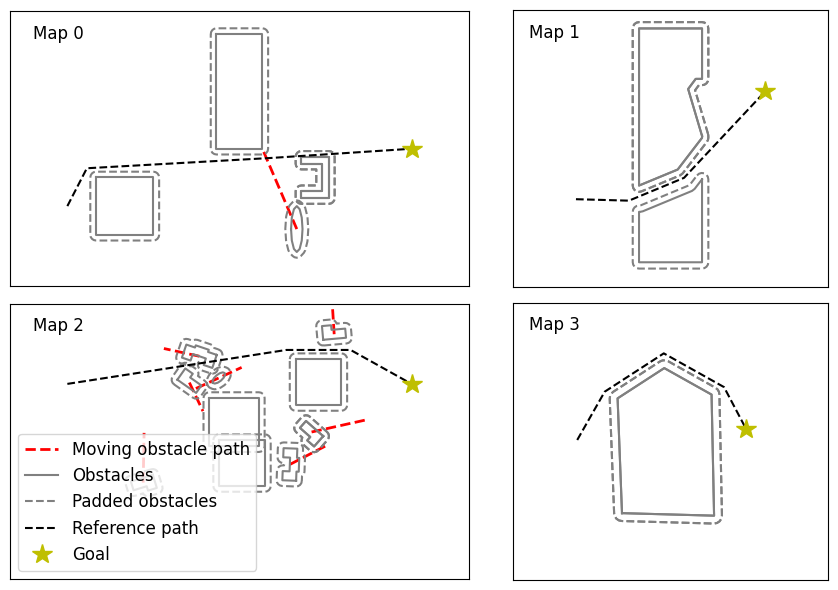

In [143]:
fig, axs = plt.subplots(2, 2, figsize=(9.2, 6))

for map in plot_maps:
    env = make_env(config, generate_map=map)
    _ = env.reset()
    map_idx = plot_maps.index(map)
    ax = axs.flatten()[map_idx]
    ax.text(0.05, 0.95, f'Map {map_idx}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    if map_idx == 0:
        plot.line(ax, [[25., 3.], [22., 10.]], "red", linestyle="--", linewidth=2, label="Moving obstacle path")
        ax.set_xlim(0, 40)
        ax.set_ylim(-2, 22)
    elif map_idx == 2:
        for i, obs in enumerate(maps_2_dynamic):
            if i == 0:
                plot.line(ax, obs, "red", linestyle="--", linewidth=2, label="Moving obstacle path")
            else:
                plot.line(ax, obs, "red", linestyle="--", linewidth=2)
        ax.set_xlim(0, 40)
        ax.set_ylim(-2, 22)
    elif map_idx == 1:
        ax.set_xlim(-5, 20)
        ax.set_ylim(-7, 15)
    else:
        ax.set_xlim(3, 23)
        ax.set_ylim(-3, 14.6)
    plot.obstacles(ax, env.unwrapped.obstacles, fmt='gray', label="Obstacles")
    plot.obstacles(ax, env.unwrapped.obstacles, padded=True,
                linestyle="--", label="Padded obstacles", fmt='gray')
    plot.reference_path(ax, env.unwrapped.path, zorder=4, label="Reference path")

axs[1,0].legend(loc="lower left", numpoints=1, fontsize=12)

plt.tight_layout()
plt.savefig("../figures/training_maps.png", dpi=400)
plt.show()